In [1]:
from src.particle_filter.parameters import ModelParameters
from src.particle_filter.transition import (
    Transition,
    OUModel,
)
from jax.random import PRNGKey
import jax.numpy as jnp



days = 100

step_beta = [0.12 for _ in range(days)]
step_beta[:20] = [0.3 for _ in range(20)]

pop = 100000
infected = 0.05 * pop
susceptible = pop - infected
initial_state = jnp.array([susceptible, infected, 0, 0, 0, 0.3])
key = PRNGKey(0)

In [2]:
print(step_beta)

[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12]


In [3]:
import paths
import os

config_path = os.path.join(paths.PF_DIR, "config.toml")

ou_model = OUModel(config_path)

det_output = [initial_state.copy()]
case_reports = [0]

In [4]:
def det_update(state, time_step):
    state = state.at[5].set(step_beta[time_step])
    update = ou_model.det_component(state, time_step)
    case_reports.append(update[4].item())
    state += update
    return state

for t in range(1, days):
    det_output.append(det_update(det_output[-1], t))

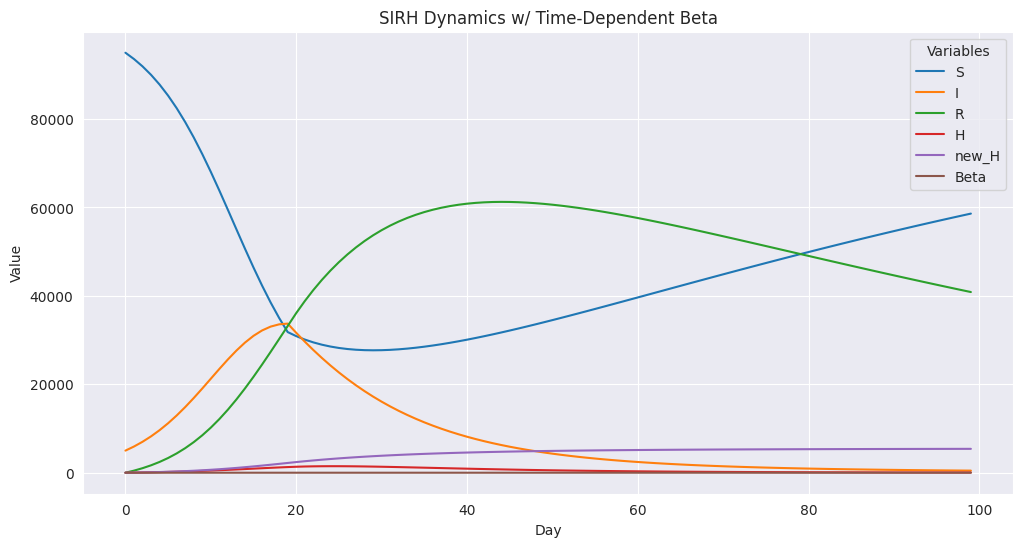

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def plot_output(output):
    data = np.array(output)
    labels = ["S", "I", "R", "H", "new_H", "Beta"]
    # Create a plot for each variable
    plt.figure(figsize=(12, 6))

    # for each day
    for i in range(data.shape[1]):
        # plot each compartment
        plt.plot(range(data.shape[0]), data[:, i], label=labels[i])

    plt.title("SIRH Dynamics w/ Time-Dependent Beta")
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend(title="Variables")
    plt.show()


plot_output(det_output)

In [6]:
# obs_data is an array of the new hospitalizations from synthetic data
data = np.array(det_output)
obs_data = data[:, 4]
print("new hospitalizations:", case_reports)

new hospitalizations: [0, 30.0, 35.54999923706055, 41.97477722167969, 49.35187530517578, 57.741573333740234, 67.17603302001953, 77.64663696289062, 89.0905990600586, 101.37855529785156, 114.3056640625, 127.58927154541016, 140.8759765625, 153.75961303710938, 165.8101806640625, 176.6102294921875, 185.79348754882812, 193.07858276367188, 198.29209899902344, 201.376953125, 202.38600158691406, 189.87413024902344, 177.9263153076172, 166.56549072265625, 155.80198669433594, 145.63621520996094, 136.06072998046875, 127.0619888305664, 118.62203216552734, 110.71957397460938, 103.33112335205078, 96.43179321289062, 89.99594116210938, 83.99771881103516, 78.41146087646484, 73.21199035644531, 68.37487030029297, 63.876556396484375, 59.694515228271484, 55.807289123535156, 52.194549560546875, 48.83711242675781, 45.716922760009766, 42.817054748535156, 40.12165451049805, 37.61592102050781, 35.28606033325195, 33.11922073364258, 31.103469848632812, 29.22771644592285, 27.48167610168457, 25.855815887451172, 24.34

In [7]:
from src.particle_filter.initialize import initialize_particle_filter

pf_algo = initialize_particle_filter(state_population=pop,
                                     location_code='04',
                                     target_date='2047-10-28',
                                     runtime=days)

In [ ]:
_, states, all_resamples, all_weights = pf_algo.run(observation_data=case_reports)  


Running Particle Filter:   5%|▌         | 5/100 [00:14<04:19,  2.73s/it]

In [8]:
true_data = data
true_data = true_data.T
true_data.shape

(6, 100)

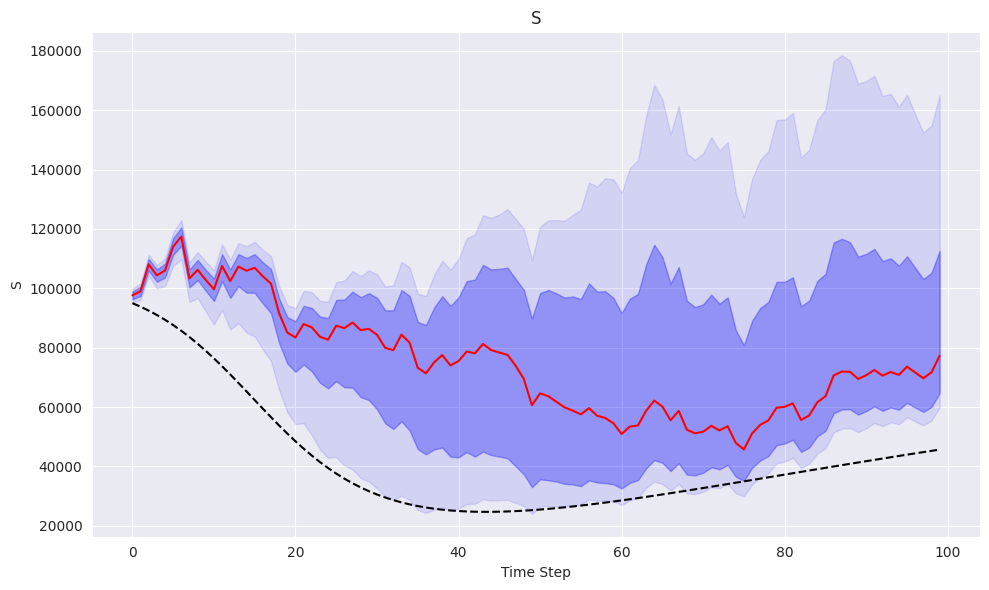

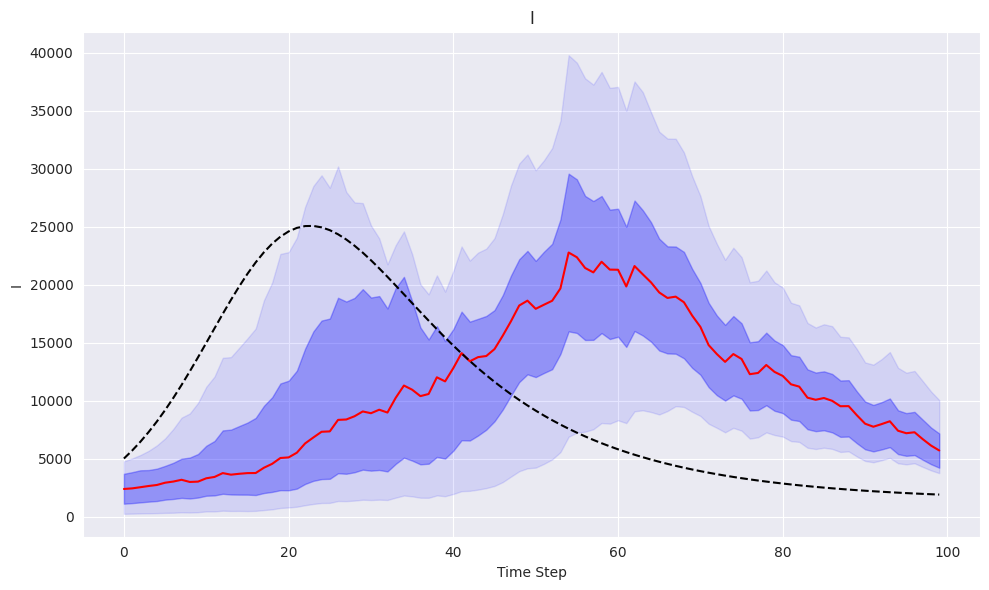

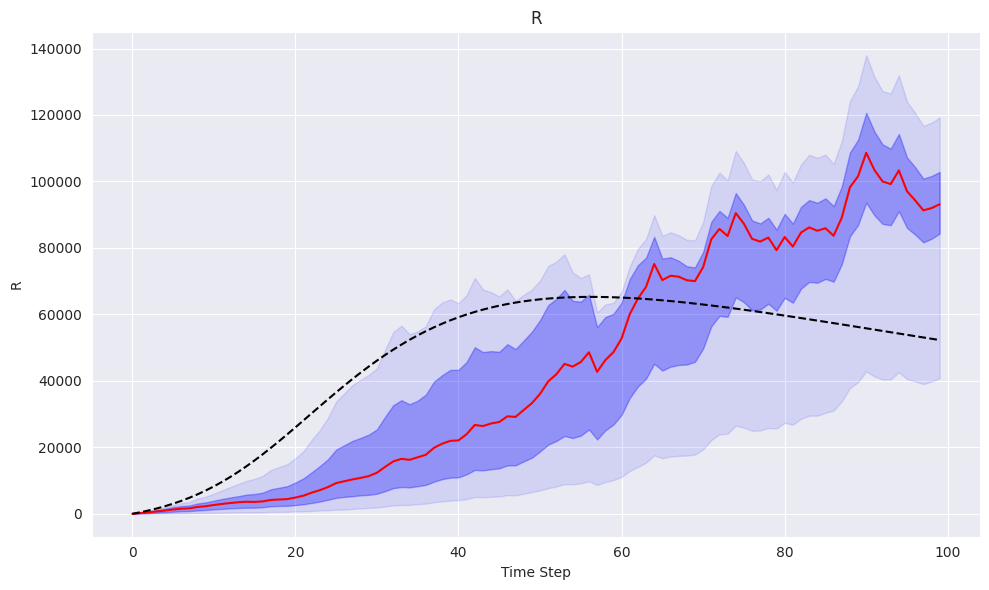

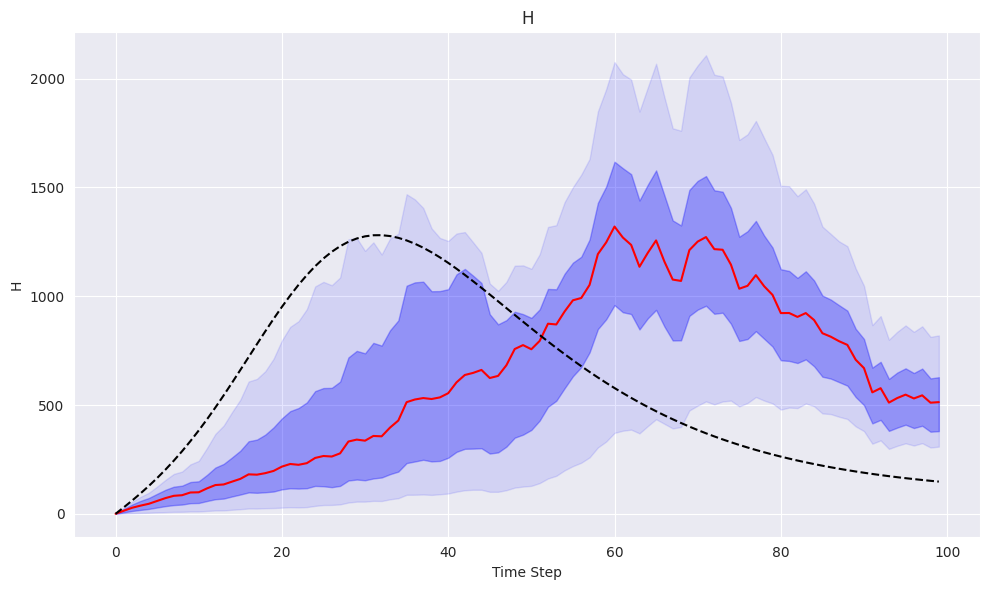

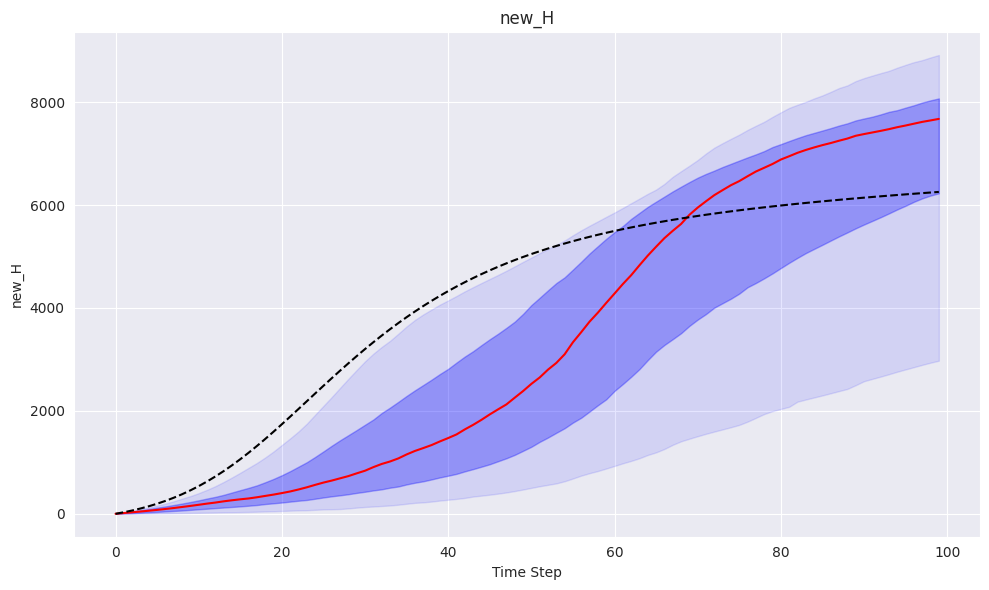

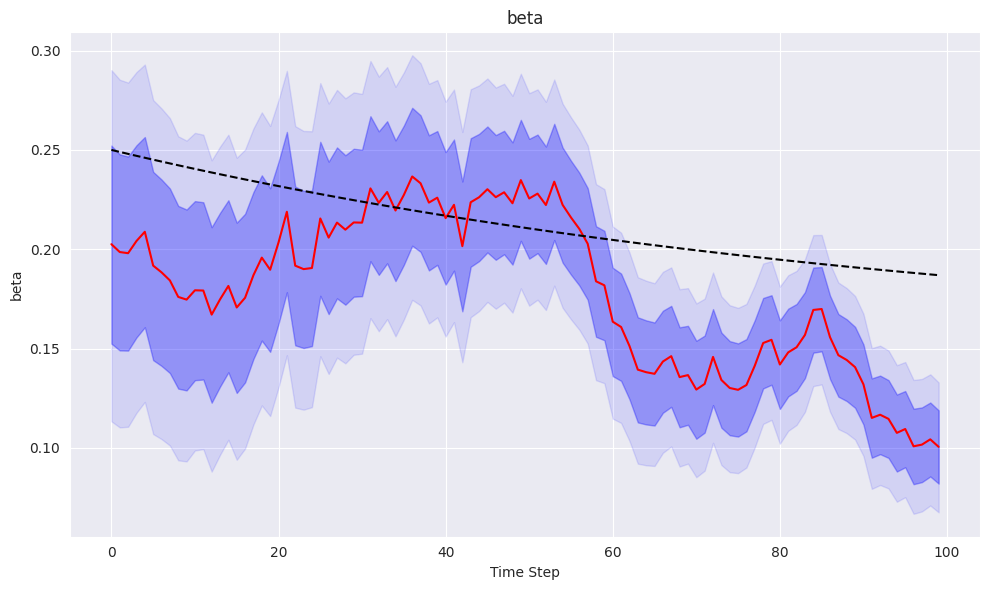

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Number of particles, state variables, and time steps
N, S, T = states.shape

state_labels = ['S', 'I', 'R', 'H', 'new_H', 'beta']

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

# Plot each state variable separately
for i in range(S):
    variable_data = states[:, i, :]  # Shape (N, T)
    
    quantile_values = np.percentile(variable_data, [q * 100 for q in quantiles], axis=0)
    
    plt.figure(figsize=(10, 6))
    
    # Fill areas between quantiles
    plt.fill_between(np.arange(T), quantile_values[0], quantile_values[-1], color='blue', alpha=0.1)
    plt.fill_between(np.arange(T), quantile_values[1], quantile_values[-2], color='blue', alpha=0.3)
    plt.plot(np.arange(T), quantile_values[2], color='red')  # Median
    plt.plot(np.arange(T), true_data[i, :], color='black', linestyle='--')  # true data
    
    plt.title(state_labels[i])
    plt.xlabel('Time Step')
    plt.ylabel(state_labels[i])
    
    plt.tight_layout()
    plt.show()
    plt.close()